# Construction d'un modèle prédictif - Partie 1

Les données sources sont issues de la plateforme Kaggle : https://www.kaggle.com/emmaren/cold-calls-data-mining-and-model-selection/data. 

Les données décrivent une base de clients d'une bancassurance, à qui a été présenté par téléphone un produit d'assurance automobile (cross-sell). L'objectif est de prédire la cible, qui vaut 1 si le client a contractualisé le nouveau produit ou 0 sinon.

In [1]:
# Il est nécessaire d'ajouter le chemin du projet au python path

# Modifiez le path de manière à ce qu'il corresponde à votre ordinateur.
import sys
sys.path.append('/Users/jms/prod/resources-intelligibility')

#sys.path.append('/home/VOTRE_IDENTIFIANT-FED/LE_CHEMIN_CHOISI/')

## 1. Présentation des données

In [2]:
import pandas as pd
from useful_functions import load_car_data, prepare_car_data

/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
bunch_data = load_car_data() ## Load raw data
task = prepare_car_data(bunch_data) ## Prepare, clean, translate and split data between training and testing set

X_train = task.X_train
X_test = task.X_test

y_train = task.y_train
y_test = task.y_test

Data were correctly read.


In [4]:
X_train.head()

,AGE,JOB,MARITAL,EDUCATION,DEFAUT,SOLDE,ASSUR_HABITATION,PRET_AUTO,CANAL_COM,NB_CONTACT,DUREE_DEPUIS_CONTACT,NB_ANCIEN_CONTACT,RESULTAT_PRECEDENT,DUREE_CONTACT
1464,52,manager,divorcé,3.0,0,2104,0,0,mobile,2,-1,0,inconnu,3.5
2548,59,technicien,marié,2.0,0,2528,0,1,inconnu,1,-1,0,inconnu,3.6
765,31,technicien,célibataire,3.0,0,882,0,0,mobile,1,-1,0,inconnu,6.8
2208,25,ouvrier,célibataire,1.0,0,2483,0,0,mobile,3,-1,0,inconnu,25.0
2534,35,ouvrier,marié,2.0,0,0,1,1,mobile,3,-1,0,inconnu,2.0


## 2. Analyse exploratoire rapide

Les 14 variables sont les suivantes : 
- Informations **générales** sur les clients
    - AGE: Age du client (en années)
    - EDUCATION: 1 pour éducation primaire, 2 pour secondaire, 3 pour supérieure
    - JOB: Catégorie de métier du client (manager, ouvrier, administratif, technicien, autoentrepreneur, retraité, au_foyer, sans_emploi, étudiant)
    - MARITAL: Statut marital du client (marié, célibataire, divorcé)
- Informations sur le **comportement client**
    - ASSUR_HABITATION: 1 si le client possède un contrat d'assurance habitation, 0 sinon
    - DEFAUT: 1 si le client est en défaut sur un de ses crédits, 0 sinon
    - PRET_AUTO: 1 si le client a un prêt auto, 0 sinon
    - SOLDE: solde moyen annuel ($)
- Informations sur les **campagnes précédentes**
    - DUREE_DEPUIS_CONTACT: nombre de jours écoulés depuis le dernier appel téléphonique de la campagne précédente (en jours), -1 si le client n'a jamais été contacté auparavant
    - NB_ANCIEN_CONTACT: nombre de contacts par téléphone, réalisés lors de la campagne précédente
    - RESULTAT_PRECEDENT: résultat de la précédente campagne (inconnu, échec, succès)
- Informations sur la **campagne en cours**
    - CANAL_COM: canal de communication utilisé lors de la campagne en cours (mobile, fixe, inconnu)
    - DUREE_CONTACT: durée de l'appel téléphonique lors du dernier contact par téléphone (en minutes)
    - NB_CONTACT: nombre de contacts par téléphone, réalisés lors de la compagne en cours

In [5]:
import pandas_profiling

profile = pandas_profiling.ProfileReport(X_train)
#profile.to_file(outputfile="./MyReport.html")
profile

Number of variables,15
Number of observations,1910
Total Missing (%),0.0%
Total size in memory,223.9 KiB
Average record size in memory,120.0 B
Numeric,8
Categorical,4
Boolean,3
Date,0
Text (Unique),0
Rejected,0


La cible à prédire décrit le comportement du client: 1 si contractualisation du produit d'assurance auto, 0 sinon. L'échantillon d'entraînement comprend 765 contractualisations pour 1145 refus.

In [6]:
pd.Series(y_train).value_counts()

0    1145
1     765
dtype: int64

## 3. Préparation des données (dummification)

In [7]:
def change_separator(df, categorical_variables, sep_in='_', sep_out='__'):
    """
    Quick fix to replace the separator introduced by the dummification.
    Example, with default parameter, variable V1 with values A, B and C 
    will be transformed into 3 variables: V1__A, V1__B and V1__C
    Without this post-processing, the __ would have been _, which are
    more confusing and more difficult to parse.
    """
    column_names_serie = pd.Series(df.columns.tolist())

    for var in categorical_variables:
        column_names_serie = column_names_serie.str.replace(var+sep_in, var+sep_out)
    
    df.columns = column_names_serie.tolist()
    return df

In [8]:
from category_encoders import OneHotEncoder
categorical_variables = ['JOB', 'MARITAL', 'CANAL_COM', 'RESULTAT_PRECEDENT']

onehot = OneHotEncoder(
    cols=categorical_variables,
    handle_unknown='ignore',
    use_cat_names=True
).fit(X_train)

X_train_dummified = change_separator(
    onehot.transform(X_train),
    onehot.cols
)

X_test_dummified = change_separator(
    onehot.transform(X_test),
    onehot.cols
)

In [9]:
X_train_dummified.head()
X_train_dummified.shape

(1910, 29)

## 4. Entraînement du modèle (Random Forest)

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42)

/Users/jms/prod/20181003_Technical_training_interpretability/.venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [11]:
%%time
clf.fit(X_train_dummified, y_train)

CPU times: user 224 ms, sys: 5.19 ms, total: 229 ms
Wall time: 235 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## 5. Analyse des performances et importance des variables

In [12]:
y_score = clf.predict_proba(X_test_dummified)[:,1]
y_score.shape

(1910,)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.84')

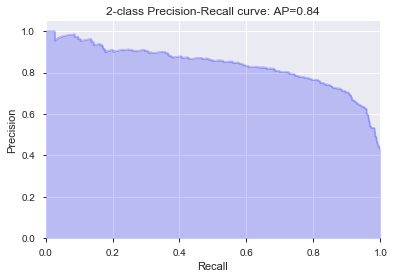

In [13]:
%matplotlib inline 
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score


average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [14]:
%matplotlib inline 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_importance(data, importances, n_feat):
    """Plot the features importance barplot.

    Parameters
    ----------
    data: DataFrame,
        data containing colnames used in the model.

    importances: numpy array,
        list of feature importances

    n_feat: int,
        number of features to plot
    """
    indices = np.argsort(importances)[::-1]
    features = data.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:n_feat],
                y=features[indices][:n_feat], palette='Blues_r')
    plt.title("Top {} Features Importance".format(n_feat))
    return plt.show()

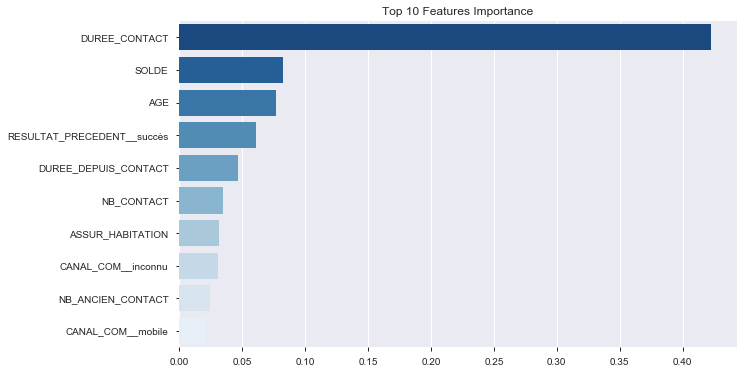

In [15]:
# Les 10 variables les plus importantes du random forest.

plot_features_importance(data=X_train_dummified, 
                         importances=clf.feature_importances_,
                         n_feat=10)

## 6. Sauvegarde du modèle et des données

In [16]:
## Dans le dictionnaire suivant sont stockés les informations nécessaires la suite de l'exercice (données + modèle)
data_model_dict = {
    'X_train': X_train_dummified,
    'X_test': X_test_dummified, 
    'y_train': y_train,
    'y_test': y_test,
    'model': clf
}

In [17]:
## Export du dictionnaire sous la forme d'un pickle
import pickle

with open('data_model_rf.pickle', 'wb') as handle:
    pickle.dump(data_model_dict, handle)